## Preamble

In [1]:
#start by importing some needed modules
#You may see some warnings... unless it spits out an error, you can ignore them!
import tangos as db
import numpy as np
import pynbody
import matplotlib.pyplot as plt
from array import array
import pickle
plt.ion()

#Set up some properties to make the plots look nice
plt.rcParams['figure.figsize'] = (12, 9) #set figure size
plt.rcParams['font.size'] = 20 #set font size so things are readible and not too small or bit
plt.rcParams['font.family'] = 'sans-serif' # just a font preference here
plt.rcParams['xtick.major.size'] = 10 #size and widths of major/minor tick marks on plots
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1


#load in the database simulation (also a good check that you are reading the right database file!)
sim = db.get_simulation('cosmo25')

In [2]:
##getting the last time step
step = db.get_timestep('cosmo25/%8192')

In [3]:
solar_metal = 0.0134

## SFR

In [4]:
data_raw = step.calculate_all("at(0.9 * radius(200),SFR_encl_25Myr)", "at(0.9 * radius(200), SFR_encl_250Myr)",'halo_number()')
SFR_master_array = []
for count, item in enumerate(data_raw[0]):
    if item != 0:
        SFR_master_array.append(item)
    elif data_raw[1][count] != 0:
        SFR_master_array.append(data_raw[1][count])
    else:
        SFR_master_array.append((6*10**4)/(250*10**6))

In [5]:
f = open('./Data/stellar_metal_BH.pkl', 'rb')
stellar_metal_BH_data = pickle.load(f)
f.close

f = open('./Data/gas_metal_BH.pkl', 'rb')
gas_metal_BH_data = pickle.load(f)
f.close()

f = open('./Data/stellar_metal.pkl', 'rb')
stellar_metal_data = pickle.load(f)
f.close()

f = open('./Data/gas_metal.pkl', 'rb')
gas_metal_data = pickle.load(f)
f.close()

f = open('./Data/stellar_h_frac.pkl', 'rb')
stellar_h_data = pickle.load(f)
f.close()

f = open('./Data/gas_h_frac.pkl', 'rb')
gas_h_data = pickle.load(f)
f.close()

In [6]:
tot_gas_mass, tot_stellar_mass, stellar_mass_prof, gas_mass_prof, gas_ox_prof, star_fe_prof, SFR_encl = step.calculate_all('Mgas',
                                  'Mstar', 
                                  'star_mass_profile', 
                                  'gas_mass_profile', 
                                  'gas_Ox_profile',
                                  'star_Fe_profile',
                                  'SFR_encl_250Myr[-1]')


## Iron Mass Fraction

In [7]:
def get_metal(arr1, metal_arr, tot_arr, i):
    delta_array = []
    delta_array = arr1[i][1:]-arr1[i][:-1]
    delta_array = np.append(arr1[i][0], delta_array)
    
    x = (np.nansum(delta_array * metal_arr[i]))/(tot_arr[i])
    
    return x

In [8]:
star_mass_dm = []
star_fe_dm = []
SFR_fe = []

loop = np.arange(len(star_fe_prof))

for i in loop:
    star_mass_dm = np.append(star_mass_dm, tot_stellar_mass[i])
    star_fe_dm = np.append(star_fe_dm, get_metal(stellar_mass_prof, star_fe_prof, tot_stellar_mass, i))
    SFR_fe = np.append(SFR_fe, SFR_master_array[i]/star_mass_dm[i])

In [9]:
gas_h = gas_h_data['gas_h']
stellar_h = stellar_h_data['stellar_h']

In [10]:
stellar_fe_h = star_fe_dm / stellar_h

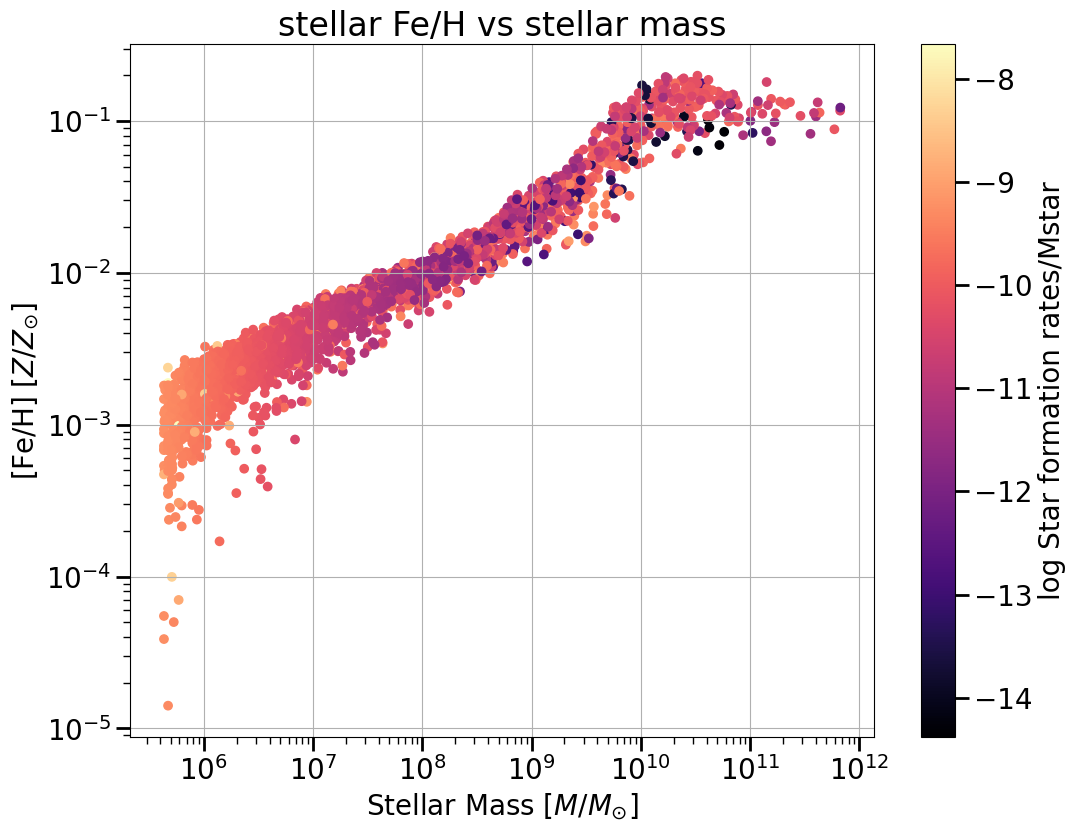

In [11]:
plt.scatter(star_mass_dm, stellar_fe_h/solar_metal, c= np.log10(SFR_fe) ,cmap='magma')

plt.xscale('log')
plt.yscale('log')

plt.title('stellar Fe/H vs stellar mass')
plt.xlabel('Stellar Mass $[M/M_{\odot}]$')
plt.ylabel('[Fe/H] $[Z/Z_{\odot}]$')
plt.colorbar(label = 'log Star formation rates/Mstar')

plt.grid()
plt.show()
#plt.savefig("./Pictures/stellar_fe_h.png", bbox_inches='tight')

### Doing the metal cut and BH filter

In [12]:
def big_get_halo_ind(arr1, num, i):
    x = []
    if arr1[i] > num:
        x = np.append(x, i)
    return x

In [13]:
def small_get_halo_ind(arr1, num2, i):
    x = []
    if arr1[i] < num2:
        x = np.append(x, i)
    return x

In [14]:
all_halo_numbers = np.array(stellar_metal_data['halo_number'])
halo_with_BH = np.unique(step.calculate_all('host_halo.halo_number()')[0])

BH_halo_ind = np.in1d(all_halo_numbers, halo_with_BH)
halo_no_BH_ind = np.in1d(all_halo_numbers, halo_with_BH, invert = True)

In [15]:
loop1 = np.arange(len(stellar_fe_h))

ind_large = []
ind_small = []

for i in loop1:
        ind_large = np.append(ind_large, big_get_halo_ind(stellar_fe_h/solar_metal, 0.03, i))
        ind_small = np.append(ind_small, small_get_halo_ind(stellar_fe_h/solar_metal, 0.03, i))
        

In [16]:
ind_large = ind_large.astype(int)
ind_small = ind_small.astype(int)

In [17]:
stellar_mass_high = star_mass_dm[ind_large]
stellar_mass_low = star_mass_dm[ind_small]

stellar_fe_h_high = stellar_fe_h[ind_large]
stellar_fe_h_low = stellar_fe_h[ind_small]

## Oxygen Mass Fraction

In [18]:
star_mass_dm = []
gas_ox_dm = []
SFR_ox = []

loop = np.arange(len(gas_ox_prof))

for i in loop:
    star_mass_dm = np.append(star_mass_dm, tot_stellar_mass[i])
    gas_ox_dm = np.append(gas_ox_dm, get_metal(gas_mass_prof, gas_ox_prof, tot_gas_mass, i))
    SFR_ox = np.append(SFR_ox, SFR_master_array[i]/star_mass_dm[i])

In [19]:
gas_ox_h = gas_ox_dm/gas_h

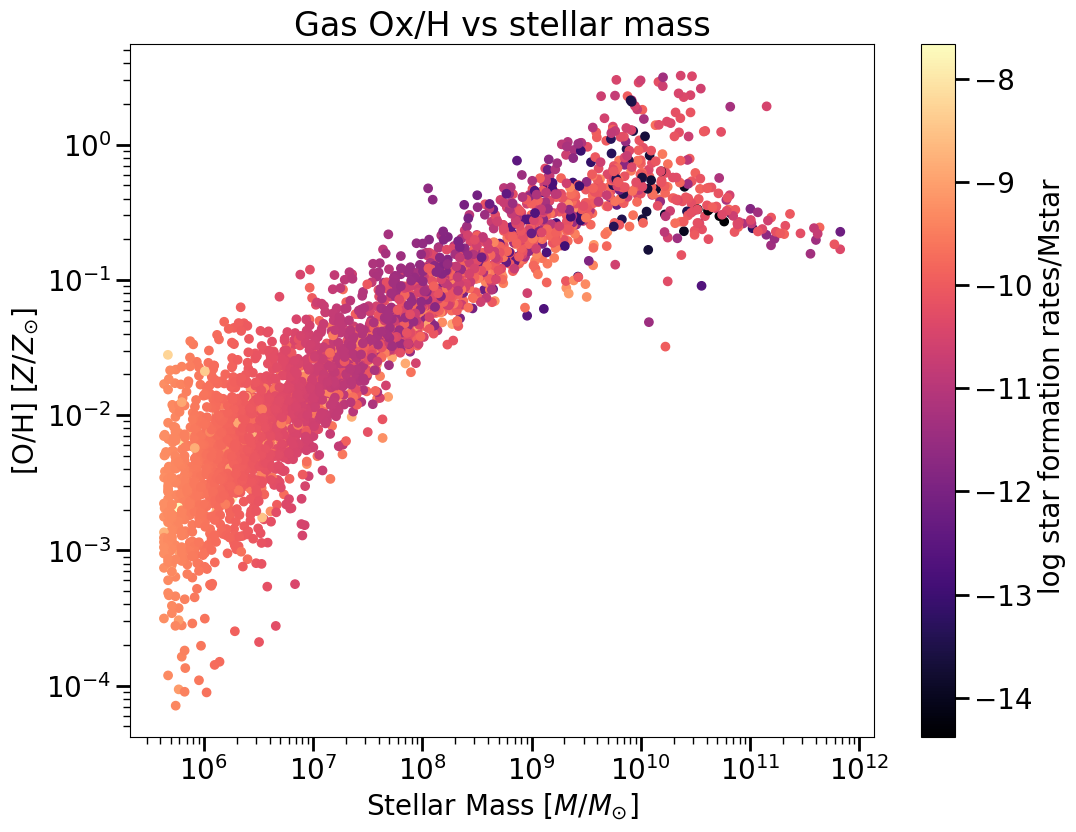

In [20]:
plt.scatter(star_mass_dm, gas_ox_h/solar_metal, c = np.log10(SFR_ox), cmap = 'magma')

plt.xscale('log')
plt.yscale('log')

plt.title('Gas Ox/H vs stellar mass')
plt.xlabel('Stellar Mass $[M/M_{\odot}]$')
plt.ylabel('[O/H] $[Z/Z_{\odot}]$')
plt.colorbar(label = ' log star formation rates/Mstar')

#plt.show()
plt.savefig("./Pictures/Gas_ox_h.png", bbox_inches='tight')

In [21]:
SFR_data = {'SFR': SFR_master_array,
            'SFR_Mstar_fe': SFR_fe,
            'SFR_Mstar_ox': SFR_ox,
            'note': 'SFR data for Fe and Ox'}

f = open('./Data/SFR_data.pkl', 'wb')
pickle.dump(SFR_data, f)
f.close()

f = open('./Data/SFR_data.pkl', 'rb')
saved_SFR_data = pickle.load(f)
f.close()

In [22]:
Fe_ox_data = {'Stellar_fe': star_fe_dm,
              'Stellar_h': stellar_h,
              'Stellar_fe_h': stellar_fe_h,
              'Gas_ox' : gas_ox_dm,
              'Gas_h': gas_h,
              'Gas_ox_h': gas_ox_h,
              'note': '[Fe/H] data for stars and [Ox/H] data for gas'}

f = open('./Data/Fe_Ox_data.pkl', 'wb')
pickle.dump(Fe_ox_data, f)
f.close()

f = open('./Data/Fe_Ox_data.pkl', 'rb')
saved_Fe_Ox_data = pickle.load(f)
f.close()